Import Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


Load Dataset & Inspect Columns

In [16]:
# Load data
data = pd.read_csv("/content/used_car_sales (1).csv")

# Clean column names (standardization)
data.columns = data.columns.str.strip()

print("Columns:")
print(data.columns.tolist())


Columns:
['ID', 'Distributor Name', 'Location', 'Car Name', 'Manufacturer Name', 'Car Type', 'Color', 'Gearbox', 'Number of Seats', 'Number of Doors', 'Energy', 'Manufactured Year', 'Price-$', 'Mileage-KM', 'Engine Power-HP', 'Purchased Date', 'Car Sale Status', 'Sold Date', 'Purchased Price-$', 'Sold Price-$', 'Margin-%', 'Sales Agent Name', 'Sales Rating', 'Sales Commission-$', 'Feedback']


Sampling the Dataset

In [17]:
# Select relevant columns (REAL NAMES)
data_sample = data.sample(n=1500, random_state=42)

print("Original size:", data.shape)
print("Sample size:", data_sample.shape)

data = data_sample


Original size: (10000, 25)
Sample size: (1500, 25)


Feature Selection

In [18]:
# Select relevant columns
data = data[
    [
        "Price-$",
        "Manufactured Year",
        "Mileage-KM",
        "Energy",
        "Gearbox",
        "Car Type",
        "Engine Power-HP"
    ]
]


Rename Columns

In [19]:
# Rename columns (for convenience)
data.rename(columns={
    "Price-$": "price",
    "Manufactured Year": "year",
    "Mileage-KM": "mileage_km",
    "Energy": "fuel",
    "Gearbox": "gearbox",
    "Car Type": "car_type",
    "Engine Power-HP": "engine_hp"
}, inplace=True)


/tmp/ipython-input-3984667101.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.rename(columns={


Data Cleaning

In [20]:
# Cleaning
data.dropna(inplace=True)
data = data[data["price"] > 0]
data = data[data["mileage_km"] > 0]
data = data[data["year"] > 1990]

data.drop_duplicates(inplace=True)

print("Shape after cleaning:", data.shape)


Shape after cleaning: (1500, 7)


/tmp/ipython-input-2163929198.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


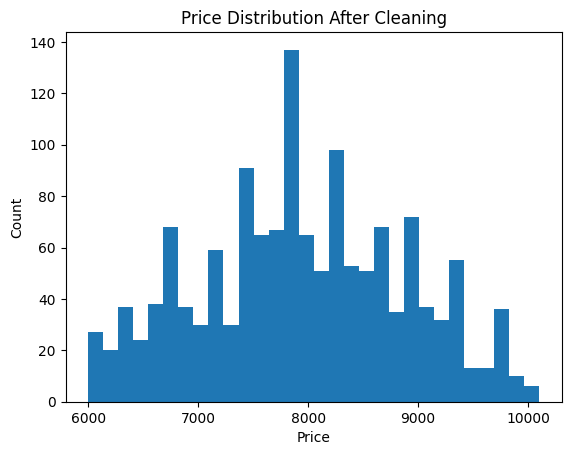

In [30]:
plt.figure()
plt.hist(data["price"], bins=30)
plt.xlabel("Price")
plt.ylabel("Count")
plt.title("Price Distribution After Cleaning")
plt.show()


Outlier Detection (Isolation Forest)

In [21]:

num_cols = ["price", "year", "mileage_km", "engine_hp"]

iso = IsolationForest(
    contamination=0.05,
    random_state=42
)

data["outlier"] = iso.fit_predict(data[num_cols])

print("Outliers detected:", (data["outlier"] == -1).sum())


Outliers detected: 75


Remove Outliers

In [22]:
data = data[data["outlier"] == 1]
data.drop(columns=["outlier"], inplace=True)

print("Shape after outlier removal:", data.shape)


Shape after outlier removal: (1425, 7)


Encoding & Scaling

In [23]:


# Encode categorical features
data_encoded = pd.get_dummies(
    data,
    columns=["fuel", "gearbox", "car_type"],
    drop_first=True
)

# Scaling
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_encoded)


KMeans Clustering

In [24]:
# KMeans
kmeans = KMeans(n_clusters=5, random_state=42)
data["cluster"] = kmeans.fit_predict(scaled_data)

print(data.head())


      price  year  mileage_km      fuel    gearbox   car_type  engine_hp  \
6252   6200  2023       43139    Diesel  Automatic  Hatchback        120   
4684   7300  2021       80457    Hybrid  Automatic  Hatchback        103   
1731   8100  2019       62489    Diesel     Manual        SUV        120   
4742   9800  2016       87903  Electric  Automatic        SUV        200   
4521   7600  2023       46711    Petrol     Manual        SUV        130   

      cluster  
6252        4  
4684        4  
1731        0  
4742        0  
4521        0  


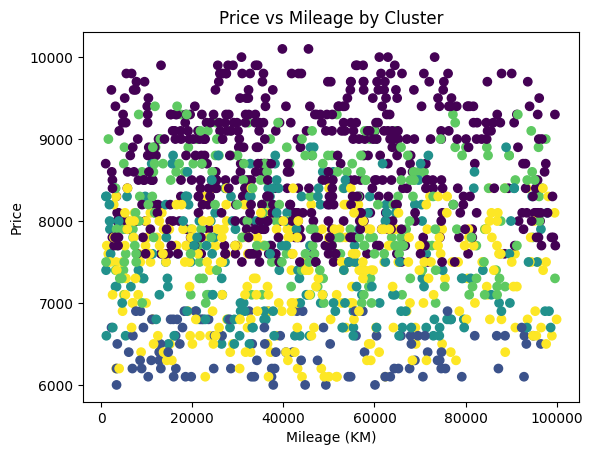

In [31]:
plt.figure()
plt.scatter(
    data["mileage_km"],
    data["price"],
    c=data["cluster"]
)
plt.xlabel("Mileage (KM)")
plt.ylabel("Price")
plt.title("Price vs Mileage by Cluster")
plt.show()


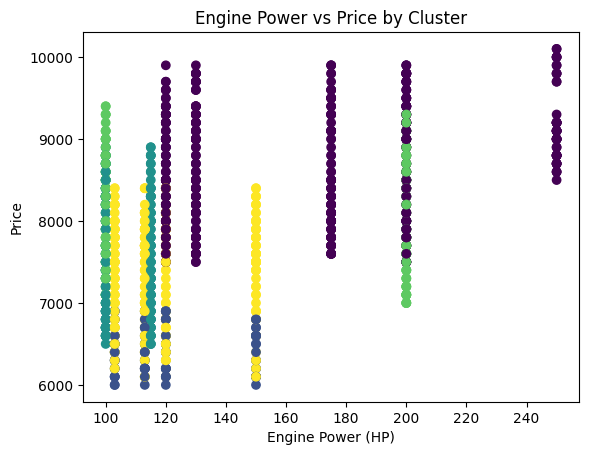

In [32]:
plt.figure()
plt.scatter(
    data["engine_hp"],
    data["price"],
    c=data["cluster"]
)
plt.xlabel("Engine Power (HP)")
plt.ylabel("Price")
plt.title("Engine Power vs Price by Cluster")
plt.show()


Cluster Summary

In [25]:
print("\nCluster Summary:")
print(data.groupby("cluster").mean(numeric_only=True))



Cluster Summary:
               price         year    mileage_km   engine_hp
cluster                                                    
0        8646.252285  2019.553931  45837.106033  167.586837
1        6450.961538  2019.490385  42305.471154  121.028846
2        7544.174757  2019.655340  44502.606796  107.208738
3        8133.609959  2019.473029  46797.120332  148.962656
4        7372.477064  2019.474006  45983.015291  119.926606


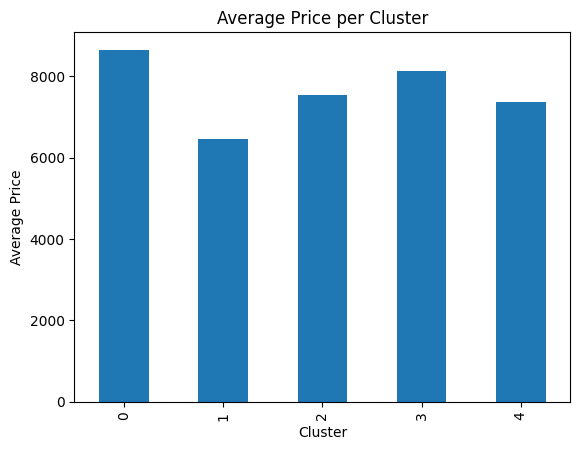

In [33]:
plt.figure()
data.groupby("cluster")["price"].mean().plot(kind="bar")
plt.xlabel("Cluster")
plt.ylabel("Average Price")
plt.title("Average Price per Cluster")
plt.show()


<Figure size 640x480 with 0 Axes>

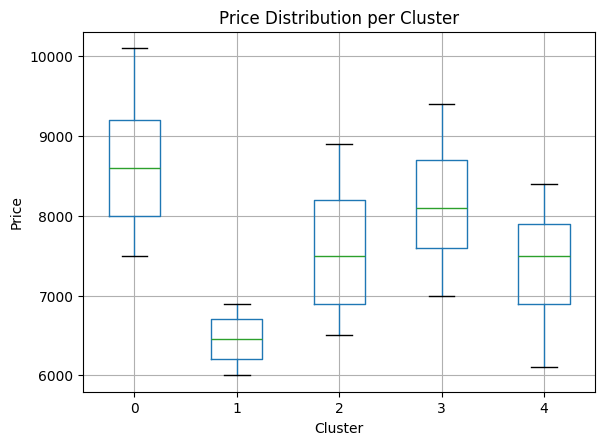

In [35]:
plt.figure()
data.boxplot(column="price", by="cluster")
plt.xlabel("Cluster")
plt.ylabel("Price")
plt.title("Price Distribution per Cluster")
plt.suptitle("")
plt.show()


Association Rule Mining (Apriori)

In [26]:

# Discretization
data_ar = data.copy()

data_ar["price_cat"] = pd.qcut(data_ar["price"], 3, labels=["Low", "Mid", "High"])
data_ar["mileage_cat"] = pd.qcut(data_ar["mileage_km"], 3, labels=["Low", "Mid", "High"])
data_ar["year_cat"] = pd.qcut(data_ar["year"], 3, labels=["Old", "Mid", "New"])


Apriori Encoding & Rule Generation

In [27]:
ar_data = data_ar[
    ["price_cat", "mileage_cat", "year_cat", "fuel", "gearbox", "car_type"]
]

ar_encoded = pd.get_dummies(ar_data)

frequent_itemsets = apriori(
    ar_encoded,
    min_support=0.05,
    use_colnames=True
)

rules = association_rules(
    frequent_itemsets,
    metric="confidence",
    min_threshold=0.6
)

print(rules[["antecedents", "consequents", "support", "confidence", "lift"]].head())


                             antecedents      consequents   support  \
0                          (fuel_Petrol)  (price_cat_Low)  0.157193   
1                   (car_type_Hatchback)  (price_cat_Low)  0.211930   
2                       (price_cat_High)   (car_type_SUV)  0.181754   
3         (mileage_cat_Low, fuel_Petrol)  (price_cat_Low)  0.055439   
4  (mileage_cat_Low, car_type_Hatchback)  (price_cat_Low)  0.072281   

   confidence      lift  
0    0.622222  1.685678  
1    0.700696  1.898274  
2    0.605140  1.745597  
3    0.686957  1.861051  
4    0.682119  1.847947  


Price Distribution Visualization

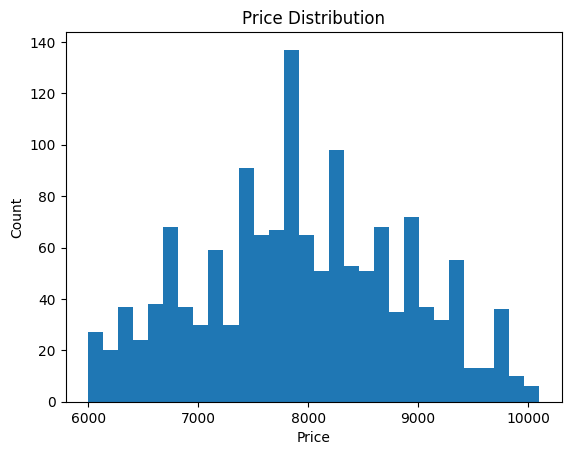

In [28]:

# Price distribution
plt.figure()
plt.hist(data["price"], bins=30)
plt.xlabel("Price")
plt.ylabel("Count")
plt.title("Price Distribution")
plt.show()


3D Clustering Visualization

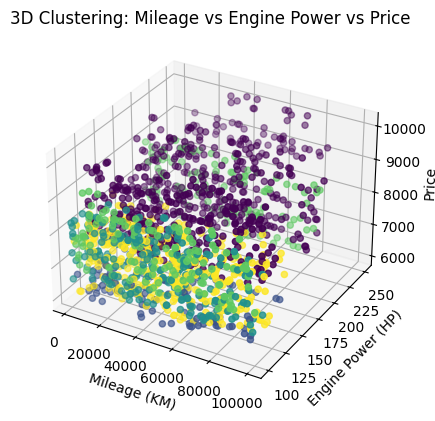

In [29]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    data["mileage_km"],
    data["engine_hp"],
    data["price"],
    c=data["cluster"]
)

ax.set_xlabel("Mileage (KM)")
ax.set_ylabel("Engine Power (HP)")
ax.set_zlabel("Price")
ax.set_title("3D Clustering: Mileage vs Engine Power vs Price")

plt.show()
